In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
os.path.append('../../common')
from scipy.special import softmax
%matplotlib inline
from common.plot_style_utils import set_pub_plot_context, save_for_pub

In [2]:
set_pub_plot_context(context="paper")
palette = sns.color_palette()
sns.set_style("white")

In [3]:
n_bins = 15 # Number of bins for calibration estimates

In [4]:
# Logits, divide by temp (copied from the scaling notebook) and softmax
seqmeta = np.load("../../../data/results/TEST_LOGITS_100_sub_MLP_full_with_metadata_300300.npy")
seqmeta = np.asarray(softmax(np.asarray(seqmeta / 1.723,dtype=np.float64), axis=1),dtype=np.float64)

In [5]:
seqonly = np.load("../../../data/results/TEST_LOGITS_100_sub_nometadata_201300.npy")
seqonly = softmax(seqonly / 1.47, axis=1)

In [6]:
print(seqmeta.shape)
seqonly.shape

(11351, 1314)


(11351, 1314)

In [7]:
true = pickle.load( open( "../../../data/tts/y_test_ord.pkl", "rb" ) )
true

array([ 142.,  142.,  142., ..., 1313., 1313., 1313.])

In [8]:
def acc(pred, true):
    classes = np.argmax(pred, axis=1)
    correct = (classes == true)
    accuracy = np.sum(correct) / len(true)
    return accuracy

def calibration(true, predicted, n_bins):
    """
    Inputs
    true: a vector of indices of the correct class
    predicted: a n_samples x n_labels matrix of softmax probabilities
    n_bins: integer > 0, number of bins to divide the interval [0,1]
    
    Outputs: ECE, MCE, bins, acc_per_bin, conf_per_bin
    """
    true = np.asarray(true,dtype=int)
    bins = np.linspace(0,1, num=n_bins, endpoint=False)
    #print(bins)
    correct = (np.argmax(predicted,axis=1) == true)
    #prob = predicted[list(zip(np.arange(len(true)),true.tolist()))]
    #prob = predicted[np.arange(len(true)),true.tolist()]
    
    # Above is for the correct, this is max confidence
    prob = np.max(predicted,axis=1)
    
    # Now I need to bin the indices of each.
    binned = np.digitize(prob,bins) - 1 # Returns bin index per row
    #print(binned)
    accs = []
    confs = []
    for bin_idx in range(n_bins):
        idxs = np.where(binned == bin_idx)
        subset = correct[idxs]
        accuracy = np.sum(subset) / len(subset)
        conf_subset = prob[idxs]
        confidence = np.sum(conf_subset) / len(conf_subset)
        accs.append(accuracy)
        confs.append(confidence)
    #print(f"acc is {accs}")
    #print(f"confs is {confs}")
    diffs = np.abs(np.asarray(accs) - np.asarray(confs))
    diffs = diffs[~np.isnan(diffs)]
    #print(diffs)
    return np.mean(prob), np.mean(diffs), np.max(diffs), bins, accs, confs

In [9]:
acc(seqmeta,true)

0.6931547881243943

In [10]:
acc(seqonly,true)

0.574310633424368

In [11]:
def topkacc(pred,true,k):
    topkclasses = np.argsort(pred)[:,-k:]
    correct = ((topkclasses == true[:,None]).any(axis=1))
    accuracy = np.sum(correct) / len(true)
    return accuracy

In [12]:
topkacc(seqonly,true,1)

0.574310633424368

In [13]:
topkacc(seqmeta,true,1)

0.6931547881243943

FOR SEQUENCE ONLY
Top 1 accuracy is 0.574310633424368
Top 2 accuracy is 0.6831116201215752
Top 3 accuracy is 0.7236366839925997
Top 4 accuracy is 0.7483041141749626
Top 5 accuracy is 0.7646903356532464
Top 6 accuracy is 0.7762311690599947
Top 7 accuracy is 0.7856576513082548
Top 8 accuracy is 0.7933221742577746
Top 9 accuracy is 0.8007224033124835
Top 10 accuracy is 0.8062725751035151
Average confidence:0.5575624704360962
ECE:0.031177979835180565
MCE:0.06067017377433137


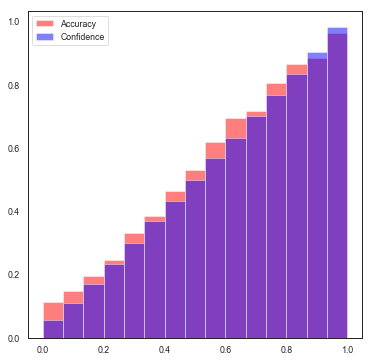

In [14]:
# That works, now check top 10
print("FOR SEQUENCE ONLY")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqonly,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqonly,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color="r", label="Accuracy", alpha=.5)
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color="b", label="Confidence", alpha=.5)
ax.legend()

FOR SEQUENCE AND METADATA
Top 1 accuracy is 0.6931547881243943
Top 2 accuracy is 0.7578186943881596
Top 3 accuracy is 0.7877720024667431
Top 4 accuracy is 0.8045987137697119
Top 5 accuracy is 0.8148180777024051
Top 6 accuracy is 0.8242445599506651
Top 7 accuracy is 0.8300590256365078
Top 8 accuracy is 0.8358734913223504
Top 9 accuracy is 0.8400140956743899
Top 10 accuracy is 0.8446832878160514
Average confidence:0.6952907863901774
ECE:0.01657231112516345
MCE:0.03711654742962457
mkdir: cannot create directory ‘../data/manuscript/figs/2/’: File exists
mkdir: cannot create directory ‘../data/manuscript/figs/2/b’: File exists


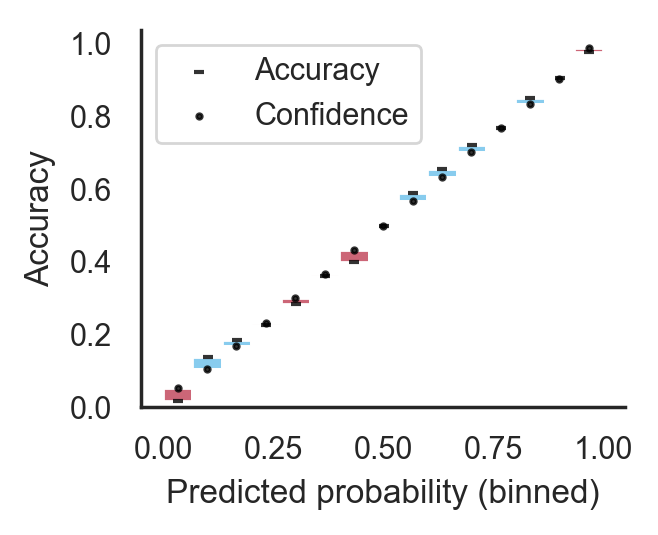

In [15]:
print("FOR SEQUENCE AND METADATA")
for i in range(10):
    print(f"Top {i+1} accuracy is {topkacc(seqmeta,true,i+1)}")
    
avg_confidence, ECE, MCE, bins, acc, conf = calibration(true,seqmeta,n_bins)
print(f"Average confidence:{avg_confidence}")
print(f"ECE:{ECE}")
print(f"MCE:{MCE}")
fig = plt.figure(figsize=(2.5,2), dpi=250)
ax = fig.add_subplot(111,
                    xlabel="Predicted probability (binned)",
                     ylabel="Accuracy"
                    )
ax.bar(left=bins, height=acc, align="edge", width=1/len(bins), color=palette[0])
ax.bar(left=bins, height=conf, align="edge", width=1/len(bins), color=palette[1])
whiteout = [acc[i] if acc[i] < conf[i] else conf[i] for i in range(len(acc)) ]
ax.bar(left=bins, height=whiteout, align="edge", width=1/len(bins), color="w", alpha=1)



# The hline is not centered by default (hence adding the small val).
ax.scatter(bins+((1/n_bins)/2)+.0009,acc,c="black", s=10, marker="_", alpha=.8, zorder=1000000, label="Accuracy")
ax.scatter(bins+((1/n_bins)/2),conf,c="black", s=10, marker=".", alpha=.8, zorder=1000000, label="Confidence")
ax.legend()
sns.despine()
!mkdir ../../../data/manuscript/figs/2/
!mkdir ../../../data/manuscript/figs/2/b
save_for_pub(fig, path="../../../data/manuscript/figs/2/b/v0", dpi=500)